In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(color_codes=True)

df = pd.read_csv('../data/Final_Monster_Data.csv')
df.head()

,Unnamed: 0,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
0,0,medium,humanoid,12.0,13,0.25,20,0,50,10,14,10,11,12,11,False,False
1,1,medium,humanoid,12.0,84,9.00,30,0,0,9,14,14,18,12,11,False,False
2,2,large,aberration,17.0,135,10.00,10,40,0,21,9,15,18,15,18,True,True
3,3,huge,monstrosity,15.0,137,9.00,40,0,0,24,10,22,9,13,9,False,False
4,4,medium,undead,21.0,285,23.00,30,0,0,13,16,20,27,21,20,False,False


In [2]:
df = df.drop('Unnamed: 0', axis = 1)

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42)

In [4]:
train

,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
132,huge,giant,14.0,200,9.00,40,0,0,27,10,22,12,16,16,False,True
340,medium,humanoid,11.0,11,0.25,30,0,0,16,12,12,9,8,6,False,False
724,medium,undead,13.0,67,5.00,0,0,60,6,16,16,12,14,15,False,False
713,medium,dragon,16.0,32,2.00,30,30,60,14,10,14,5,10,11,False,False
692,medium,humanoid,11.0,49,4.00,30,0,0,9,13,11,11,12,18,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,medium,undead,12.0,58,4.00,0,0,40,1,14,10,12,11,17,False,False
106,medium,dragon,17.0,32,2.00,30,30,60,17,10,15,12,11,15,False,False
270,huge,beast,12.0,157,7.00,40,0,0,23,14,18,7,12,7,False,True
435,medium,fiend,13.0,33,1.00,30,0,0,14,8,13,5,8,5,False,False


In [5]:
test

,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
196,medium,humanoid,12.0,45,7.0,30,0,0,9,14,10,17,13,12,False,False
260,medium,elemental,16.0,85,6.0,15,0,0,20,14,20,11,12,11,False,False
39,gargantuan,dragon,20.0,333,20.0,40,40,80,26,10,26,10,13,14,True,True
449,large,fiend,19.0,253,21.0,30,0,0,26,19,22,21,18,23,True,True
595,medium,humanoid,12.0,31,0.0,30,0,0,10,12,10,15,16,13,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,tiny,beast,13.0,1,0.0,10,0,60,5,16,8,2,14,6,False,False
220,huge,ooze,16.0,115,10.0,20,0,0,15,16,21,22,13,18,False,False
145,tiny,undead,12.0,2,0.0,20,0,0,13,14,11,5,10,4,False,False
377,medium,monstrosity,12.0,32,1.0,30,30,0,13,10,14,8,10,6,False,False


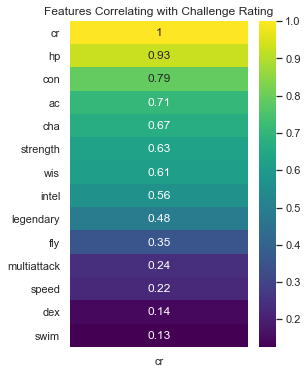

In [6]:
CR_corr = df.corr()[['cr']].sort_values(by='cr', ascending=False)

plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(CR_corr, annot=True, cmap="viridis")
heatmap.set_title('Features Correlating with Challenge Rating');

In [7]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
X_train = train[['hp', 'con', 'ac', 'cha']]
y_train = train['cr']

linreg.fit(X_train, y_train)

LinearRegression()

In [8]:
X_test = test[['hp', 'con', 'ac', 'cha']]
y_test = test['cr']

In [9]:
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

In [10]:
from sklearn.metrics import mean_squared_error

